# Cohort Analysis with Python
## What is cohort analysis?

A cohort is a group of users who share something in common, be it their sign-up date, first purchase month, birth date, acquisition channel, etc. Cohort analysis is the method by which these groups are tracked over time, helping you spot trends, understand repeat behaviors (purchases, engagement, amount spent, etc.), and monitor your customer and revenue retention.

It’s common for cohorts to be created based on a customer’s first usage of the platform, where "usage" is dependent on your business’ key metrics. For Uber or Lyft, usage would be booking a trip through one of their apps. For GrubHub, it’s ordering some food. For AirBnB, it’s booking a stay.

With these companies, a purchase is at their core, be it taking a trip or ordering dinner — their revenues are tied to their users’ purchase behavior.

In others, a purchase is not central to the business model and the business is more interested in "engagement" with the platform. Facebook and Twitter are examples of this - are you visiting their sites every day? Are you performing some action on them - maybe a "like" on Facebook or a "favorite" on a tweet?1

When building a cohort analysis, it’s important to consider the relationship between the event or interaction you’re tracking and its relationship to your business model.

## Why is it valuable?

Cohort analysis can be helpful when it comes to understanding your business’ health and "stickiness" - the loyalty of your customers. Stickiness is critical since it’s far cheaper and easier to keep a current customer than to acquire a new one. For startups, it’s also a key indicator of product-market fit.

Additionally, your product evolves over time. New features are added and removed, the design changes, etc. Observing individual groups over time is a starting point to understanding how these changes affect user behavior.

It’s also a good way to visualize your user retention/churn as well as formulating a basic understanding of their lifetime value.

#### import modules

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline 

#### customizing matplotlib

In [2]:
plt.style.use('fivethirtyeight')

width, height = plt.figaspect(4)
fig = plt.figure(figsize=(width,height), dpi=400)
from matplotlib import rcParams
plt.style.use('fivethirtyeight')
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = 'DejaVu Sans'
plt.rcParams['font.monospace'] = 'Ubuntu Mono'
plt.rcParams['font.size'] = 6
plt.rcParams['axes.labelsize'] = 6
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['axes.titlesize'] = 6
plt.rcParams['xtick.labelsize'] = 6
plt.rcParams['ytick.labelsize'] = 6
plt.rcParams['legend.fontsize'] = 10
plt.rcParams['figure.titlesize'] = 12

#### load a csv

In [3]:
df = pd.read_csv('sessions_df.csv')
df.head(15)

,country_code,session_id,user_id,session_date
0,135,1158546,135-39902,2016-11-27
1,135,1572603,135-43797,2017-02-05
2,135,1573327,135-43797,2017-02-05
3,135,1134179,135-46674,2016-11-23
4,135,1463140,135-48489,2017-01-20
5,135,1484179,135-58012,2017-01-22
6,135,1574454,135-58502,2017-02-05
7,135,1727708,135-78350,2017-02-26
8,135,2402483,135-83125,2017-05-31
9,135,2112882,135-78144,2017-04-24


In [4]:
# count unique users
df['user_id'].nunique()

5431

#### 1. Create a period column based on the SessionDate

Since we're doing monthly cohorts, we'll be looking at the total monthly behavior of our users. Therefore, we don't want granular SessionDate data (right now).

In [5]:
# cast 'session_date' as date
from datetime import datetime
df['session_date'] = pd.to_datetime(df['session_date'])

In [6]:
# add a new column with order month 
# Lambda lets you define one-line mini-functions 
# time.strftime(format[, t]) 
# %m - month (01 to 12)

df['SessionPeriod'] = df.session_date.apply(lambda x: x.strftime('%Y-%m'))
df.head(10)

,country_code,session_id,user_id,session_date,SessionPeriod
0,135,1158546,135-39902,2016-11-27,2016-11
1,135,1572603,135-43797,2017-02-05,2017-02
2,135,1573327,135-43797,2017-02-05,2017-02
3,135,1134179,135-46674,2016-11-23,2016-11
4,135,1463140,135-48489,2017-01-20,2017-01
5,135,1484179,135-58012,2017-01-22,2017-01
6,135,1574454,135-58502,2017-02-05,2017-02
7,135,1727708,135-78350,2017-02-26,2017-02
8,135,2402483,135-83125,2017-05-31,2017-05
9,135,2112882,135-78144,2017-04-24,2017-04


#### 2. Determine the user's cohort group (based on their first session)

Create a new column called CohortGroup, which is the year and month in which the user's first visit occurred.

In [7]:
# Set the DataFrame index (row labels) using one or more existing columns.
df.set_index('user_id', inplace=True)

# Creare Cohort Group base on first session date of the user
df['CohortGroup'] = df.groupby(level=0)['session_date'].min().apply(lambda x: x.strftime('%Y-%m'))
df.reset_index(inplace=True)

In [8]:
user_tot = df.groupby(['SessionPeriod', 'user_id']).sum()
user_tot.reset_index(inplace=True)
user_tot.head()


,SessionPeriod,user_id,country_code,session_id
0,2016-09,135-22418,1620,9685818
1,2016-09,135-22419,2835,16560080
2,2016-09,135-22420,2025,12006473
3,2016-09,135-22421,1620,9778321
4,2016-09,135-22428,2295,13674100


#### 3. Rollup data by CohortGroup & OrderPeriod

Since we're looking at monthly cohorts, we need to aggregate users, orders, and amount spent by the CohortGroup within the month (OrderPeriod).

In [9]:
grouped = df.groupby(['CohortGroup', 'SessionPeriod'])
grouped_1=grouped
# count the unique users, orders, and total revenue per Group + Period
cohorts = grouped.agg({'user_id': pd.Series.nunique,
                       'session_id': pd.Series.nunique})

# make the column names more meaningful
cohorts.rename(columns={'user_id': 'TotalUsers',
                        'session_date': 'TotalSession'}, inplace=True)
cohorts.head()

TotalUsers  session_id
CohortGroup SessionPeriod                        
2016-09     2016-09               123        3905
            2016-10               115       13097
            2016-11               103        9515
            2016-12                73        7093
            2017-01                66        7300

#### 4. Label the CohortPeriod for each CohortGroup

We want to look at how each cohort has behaved in the months following their first purchase, so we'll need to index each cohort to their first purchase month. For example, CohortPeriod = 1 will be the cohort's first month, CohortPeriod = 2 is their second, and so on.

This allows us to compare cohorts across various stages of their lifetime.

In [10]:
def cohort_period(df):
    """
    Creates a `CohortPeriod` column, which is the Nth period based on the user's first purchase.
    
    Example
    -------
    Say you want to get the 3rd month for every user:
        df.sort(['UserId', 'OrderTime', inplace=True)
        df = df.groupby('UserId').apply(cohort_period)
        df[df.CohortPeriod == 3]
    """
    df['CohortPeriod'] = np.arange(len(df)) + 1
    return df

cohorts = cohorts.groupby(level=0).apply(cohort_period)

In [11]:
# reindex the DataFrame
cohorts.reset_index(inplace=True)
cohorts.set_index(['CohortGroup', 'CohortPeriod'], inplace=True)

# create a Series holding the total size of each CohortGroup
cohort_group_size = cohorts['TotalUsers'].groupby(level=0).first()


In [12]:
user_retention = cohorts['TotalUsers'].unstack(0).divide(cohort_group_size, axis=1)
user_retention_abs = cohorts['TotalUsers'].unstack(0)
user_retention.head(10)
user_retention



CohortGroup,2016-09,2016-10,2016-11,2016-12,2017-01,2017-02,2017-03,2017-04,2017-05,2017-06,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12
CohortPeriod,,,,,,,,,,,,,,,,
1,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0
2,0.934959,0.885463,0.855159,0.878187,0.856823,0.878587,0.921615,0.950658,0.885522,0.916168,0.907609,0.896774,0.764350,0.849673,0.837989,NaN
3,0.837398,0.685022,0.688492,0.713881,0.738255,0.697572,0.755344,0.753289,0.734007,0.700599,0.722826,0.716129,0.561934,0.566449,NaN,NaN
4,0.593496,0.552863,0.565476,0.645892,0.592841,0.562914,0.593824,0.625000,0.558923,0.544910,0.543478,0.548387,0.401813,NaN,NaN,NaN
5,0.536585,0.471366,0.503968,0.563739,0.472036,0.456954,0.534442,0.509868,0.454545,0.449102,0.429348,0.374194,NaN,NaN,NaN,NaN
6,0.495935,0.416300,0.458333,0.484419,0.411633,0.381898,0.451306,0.411184,0.343434,0.317365,0.298913,NaN,NaN,NaN,NaN,NaN
7,0.439024,0.365639,0.386905,0.399433,0.335570,0.320088,0.396675,0.319079,0.252525,0.239521,NaN,NaN,NaN,NaN,NaN,NaN
8,0.414634,0.323789,0.343254,0.348442,0.295302,0.293598,0.325416,0.243421,0.198653,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,0.422764,0.306167,0.313492,0.305949,0.246085,0.264901,0.287411,0.190789,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Finally, we can plot the cohorts over time in an effort to spot behavioral differences or similarities. Two common cohort charts are line graphs and heatmaps, both of which are shown below.

Notice that the first period of each cohort is 100% -- this is because our cohorts are based on each user's first purchase, meaning everyone in the cohort purchased in month 1.

In [13]:
s = " CARLO OLMI   -   Data Scientist " 

C:\Users\carlo.olmi\AppData\Local\Continuum\Anaconda2\lib\site-packages\matplotlib\font_manager.py:1297: UserWarning: findfont: Font family [u'Ubuntu'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


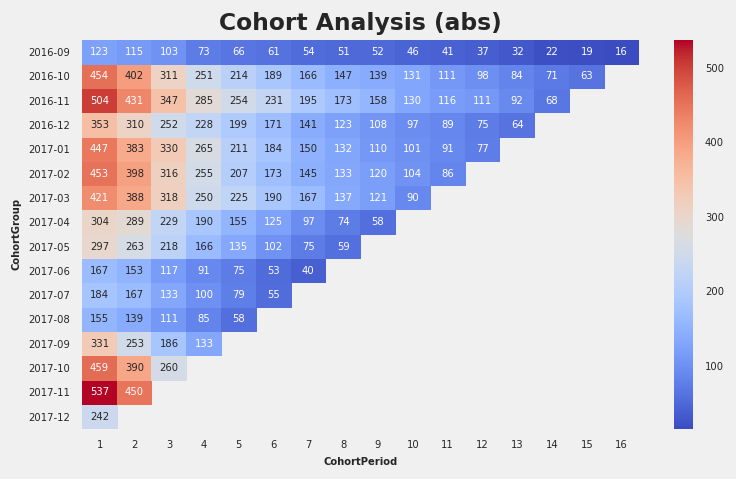

In [14]:
width, height = plt.figaspect(.6)
fig = plt.figure(figsize=(width,height), dpi=120)
#plt.text(-1.6, 19.0, s = 'Cohort Analysis (%)', fontsize = 14,  fontweight='bold')#", fontname='Ubuntu', fontsize=14, fontweight='semibold')
#plt.text(-1.6, 16.7, s = 'Cohort analysis is a subset of behavioral analytics that takes the data from a \ngiven dataset and rather than looking at all users as one unit, it breaks them \ninto related groups for analysis.', fontsize = 9,  fontweight='medium')
plt.title("Cohort Analysis (abs)", fontname='Ubuntu', fontsize=14, fontweight='bold')
sns.heatmap(user_retention_abs.T, mask=user_retention.T.isnull(), annot=True, fmt='g', cmap='coolwarm') 

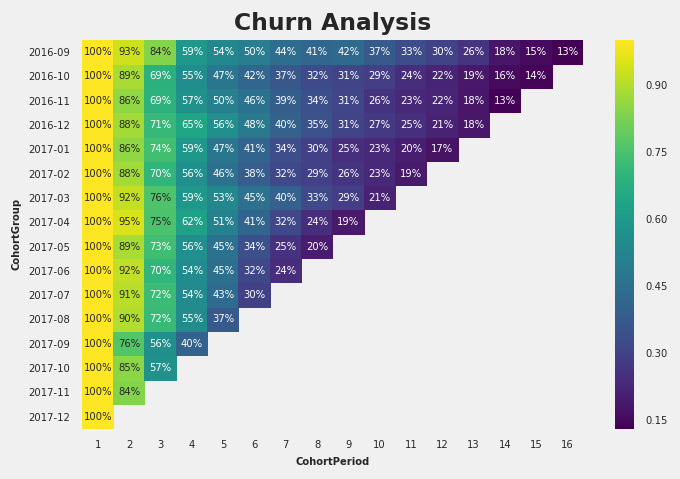

In [15]:

width, height = plt.figaspect(.6)
fig = plt.figure(dpi=120)
#plt.text(-1.6, 19.0, s = 'Cohort Analysis (%)', fontsize = 14,  fontweight='bold')#", fontname='Ubuntu', fontsize=14, fontweight='semibold')
#plt.text(-1.6, 16.7, s = 'Cohort analysis is a subset of behavioral analytics that takes the data from a \ngiven dataset and rather than looking at all users as one unit, it breaks them \ninto related groups for analysis.', fontsize = 9,  fontweight='medium')

plt.title("Churn Analysis", fontname='Ubuntu', fontsize=14, fontweight='bold')
sns.heatmap(user_retention.T, mask=user_retention.T.isnull(), annot=True, fmt='0.00%', cmap='viridis') 

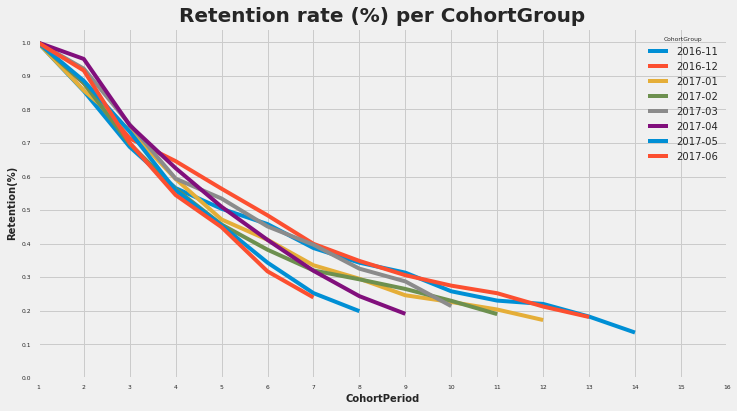

In [16]:
width, height = plt.figaspect(.6)
fig = plt.figure(dpi=150)


ax = user_retention[['2016-11','2016-12','2017-01', '2017-02','2017-03','2017-04','2017-05','2017-06']].plot(figsize=(11,6))
plt.title("Retention rate (%) per CohortGroup", fontname='Ubuntu', fontsize=20, fontweight='bold')

plt.xticks(np.arange(1, 16.1, 1))
plt.yticks(np.arange(0, 1.1, 0.1))
ax.set_xlabel("CohortPeriod", fontsize=10)
ax.set_ylabel("Retention(%)", fontsize=10)
plt.show()

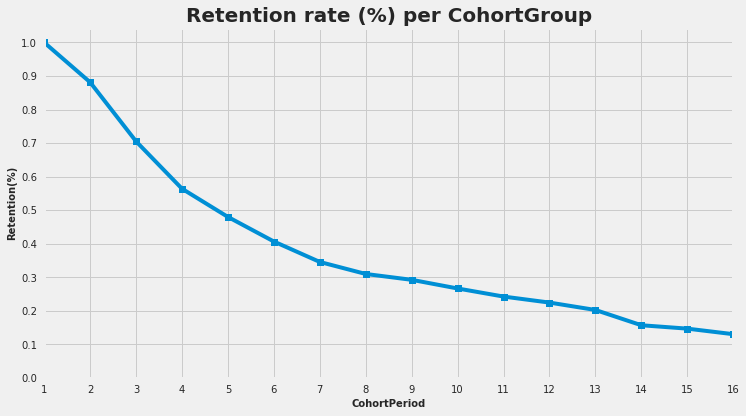

In [17]:
ax = user_retention.T.mean().plot(figsize=(11,6), marker='s')
plt.title("Retention rate (%) per CohortGroup", fontname='Ubuntu', fontsize=20, fontweight='bold')

plt.xticks(np.arange(1, 16.1, 1), fontsize=10)
plt.yticks(np.arange(0, 1.1, 0.1), fontsize=10)
ax.set_xlabel("CohortPeriod", fontsize=10)
ax.set_ylabel("Retention(%)", fontsize=10)
plt.show()